Conservation laws for a ReLu MLP.
------

This is the code to reproduce the numerical simulation of the paper

> _Keep the Momentum: Conservation Laws beyond Gradient Flows_

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import matplotlib.pyplot as plt
import progressbar
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Full batch training, so we use the entire dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
# get them directly into arrays (since we do full batch training)
train_features, train_labels = next(iter(trainloader))
test_features, test_labels = next(iter(testloader))
# Move the data to the device
train_features, train_labels = train_features.to(device), train_labels.to(device)
test_features, test_labels = test_features.to(device), test_labels.to(device)

100%|██████████| 9912422/9912422 [00:00<00:00, 113809398.17it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 14606981.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32095133.20it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17085676.03it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Define a Multi-Layer Perceptron model.

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We consider optimization with momentum:
$$
    x(t+1) = x(t) - \alpha \nabla f(x(t)) + \beta (x(t)-x(t-1))
$$
set $\beta=0$ to recover gradient descent and $0 \leq \beta \leq 1$ ($\beta=1$ is pure momentum).

This can be conveniently implemented using a momentum variable $m(t) := \frac{ x(t-1)-x(t) }{\alpha}$ as
$$
		m(t+1) = \beta m(t) + (1-\beta) \nabla f(x(t))
$$
$$
		x(t+1) = x(t) - \xi m(t+1)
$$
where $\xi := \alpha/(1-\beta)$, see Irene's lecture note.

An alternate parameterizaton is to consider the second order ODE
$$
	\mu \ddot x + \nu \dot x = -\nabla f(x)
$$
For instance on can use $\mu=1$ and $\nu=\tau$ if one does not aim at gradient flows, which can be discretized as
$$
	  \mu ( x(t+1) + x(t-1) - 2 x(t) ) / \delta^2 + \nu ( x(t+1) - x(t) ) / \delta = -\nabla f(x(t))
$$
so that
$$
	[\nu + \mu/\delta] x(t+1) - [ \nu + 2 \mu/\delta  ] x(t)
  + \mu/\delta  x(t-1) = -\delta \nabla f(x(t))
$$
so
$$
	[\nu + \mu/\delta] x(t+1)  = [\nu + \mu/\delta] x(t) + \mu/\delta ( x(t) - x(t-1) ) - \delta \nabla f(x(t))
$$
so that one has the following remapping of parameters
$$
	\alpha = \frac{\delta}{\nu + \mu/\delta}
  \quad\text{and}\quad
	\beta =  \frac{ \mu/\delta }{ \nu + \mu/\delta } =
  \frac{\mu}{ \delta \nu + \mu} \leq 1
$$


Training: 100% |###############################################| Time:  0:00:22
Training: 100% |###############################################| Time:  0:00:23
Training: 100% |###############################################| Time:  0:00:22
Training: 100% |###############################################| Time:  0:00:22


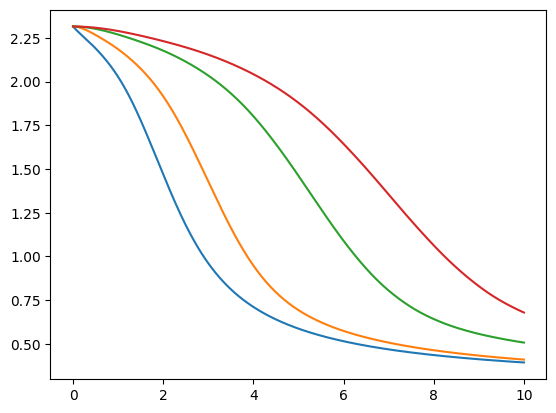

In [45]:
Tmax = 1.0*10

test_type = 'step_size'
test_type = 'momentum'

if test_type=='step_size': # Testing step size
  # param for non momentum
  delta_list = Tmax/150.0*torch.tensor( [.02, .25, .5, 1, 1.25] )
  mu_list = torch.zeros(len(delta_list)) # + .6  # uncomment if you want no momentum
  nu_list = torch.ones(len(delta_list))
  Col = [np.array([0, 0, 1]), np.array([1, 0, 0])] # color used for display
elif test_type=='momentum':
  # Testing momentum
  mu_list = torch.tensor([0, .01, .05, .1])*50
  delta_list = Tmax/500 * torch.ones(len(mu_list)) # step size
  nu_list = torch.ones(len(mu_list))
  Col = [np.array([1, 0, 1]), np.array([0, 1, 0])] # color used for display

H_list = [] # to stored conservation laws
Loss_list = []
model0 = MLP().to(device) # same initialization for every run

for it in range(len(delta_list)):
  mu = mu_list[it]
  nu = nu_list[it]
  delta = delta_list[it]
  # conversion to discrete parameters
  alpha = delta / (nu + mu/delta)
  beta = mu/( delta * nu + mu )
  # number of iterations of the descent to reach Tmax
  niter = ( Tmax/delta ).int().item()

  # Initialize the model and loss function
  model = MLP().to(device)
  model.load_state_dict(model0.state_dict())
  criterion = nn.CrossEntropyLoss()
  # Initialize momentum term for each parameter
  momentum = {p: torch.zeros_like(p.data) for p in model.parameters()}

  d = 512 # number of neurons on first layer
  loss_list = torch.zeros(niter, device=device)
  H = torch.zeros(d, niter, device=device)

  # Training loop with progress bar
  widgets = ['Training: ', progressbar.Percentage(), ' ',
            progressbar.Bar(), ' ', progressbar.ETA()]
  bar = progressbar.ProgressBar(maxval=niter, widgets=widgets).start()

  for epoch in range(niter):

      for p in model.parameters():
          p.grad = None  # Reset gradients

      outputs = model(train_features)
      loss = criterion(outputs, train_labels)
      loss.backward()

      with torch.no_grad():
          for p in model.parameters():
              if p.grad is not None:
                  # Update momentum
                  momentum[p] = beta * momentum[p] + (1-beta) * p.grad
                  # Update parameters
                  p -= alpha/(1-beta) * momentum[p]

      # conserved functions for gradient flows
      U = model.fc2.weight #.T
      V = model.fc1.weight #.T
      H[:,epoch] = ( U**2 ).sum(axis=0) - ( V**2 ).sum(axis=1)

      loss_list[epoch] = loss.item()
      bar.update(epoch + 1)

  H_list.append(H.detach())
  Loss_list.append(loss_list)
  bar.finish()
  plt.plot(torch.linspace(0,Tmax,niter), loss_list.cpu());


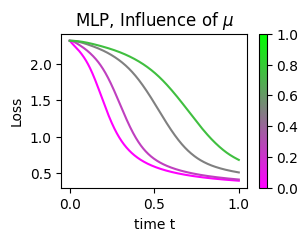

In [46]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

plt.figure(figsize=(3, 2))
ax = plt.gca()
for it in range(len(delta_list)):
  H = Loss_list[it].cpu()
  niter = len(H)
  c = (1.0-it/len(delta_list))*Col[0] + it/len(delta_list)*Col[1]
  lgd_str = 'MLP, '
  if mu_list.std()>0:
    lgd_str += 'Influence of $\\mu$'
  if nu_list.std()>0:
    lgd_str += 'Influence of $\\nu$'
  if delta_list.std()>0:
    lgd_str += 'Influence of #iter=$t_{\max}/\delta$'
  plt.plot(torch.linspace(0,1,niter), H, color=c)
ax.set_ylabel('Loss')
ax.set_xlabel('time t')
plt.title(lgd_str)
if test_type=='step_size':
  cmap = LinearSegmentedColormap.from_list('custom_colormap', [Col[1], Col[0]])
  sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(Tmax/max(delta_list), Tmax/min(delta_list) ))
else:
  cmap = LinearSegmentedColormap.from_list('custom_colormap', [Col[0], Col[1]])
  sm = ScalarMappable(cmap=cmap, norm=plt.Normalize( 0,1 ))
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='vertical')
plt.savefig('mlp_loss.pdf', format='pdf')


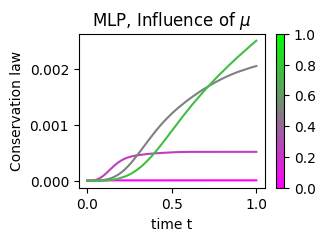

In [51]:
k = 5
plt.figure(figsize=(3, 2))
ax = plt.gca()
for it in range(len(delta_list)):
  H = H_list[it].cpu()
  niter = H.shape[-1]
  c = (1.0-it/len(delta_list))*Col[0] + it/len(delta_list)*Col[1]
  lgd_str = 'MLP, '
  if mu_list.std()>0:
    lgd_str += 'Influence of $\\mu$'
  if nu_list.std()>0:
    lgd_str += 'Influence of $\\nu$'
  if delta_list.std()>0:
    lgd_str += 'Influence of #iter=$t_{\max}/\delta$'
  plt.plot(torch.linspace(0,1,niter), ( H[k,:].T - H[k,0] ) / H.max(), color=c)
ax.set_ylabel('Conservation law')
ax.set_xlabel('time t')
plt.title(lgd_str)
if test_type=='step_size':
  cmap = LinearSegmentedColormap.from_list('custom_colormap', [Col[1], Col[0]])
  sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(Tmax/max(delta_list), Tmax/min(delta_list) ))
else:
  cmap = LinearSegmentedColormap.from_list('custom_colormap', [Col[0], Col[1]])
  sm = ScalarMappable(cmap=cmap, norm=plt.Normalize( 0,1 ))
sm.set_array([])
plt.colorbar(sm, ax=ax, orientation='vertical')
plt.savefig('mlp_laws.pdf', format='pdf')